In [71]:
POWER_CONSUMPTIONS = [1., 0.47, 0.105, 0]
WAKE_UP_COSTS = [0, 0.12, 0.33, 1.] # assume all are interesting at some point
#same as Antoniadis et al.

In [72]:
import numpy as np

# offline otpimum
def OPT(requests):
    res = [0] * len(requests)
    for t, req in enumerate(requests):
        res[t] = 0 if req>=1 else req+1000
    return res

# blindly trust
def FTP(requests, pred):
    res = [0] * len(requests)
    for t, req in enumerate(requests):
        res[t] = 0 if pred[t]>=1 else requests[t]+1000
    return res

## Randomized Algorithms

In [73]:
import import_ipynb
import Randomized_Ski_Rental


def Kumar_pi(pred, lambd):
    return Randomized_Ski_Rental.kumar_distribution(lambd, 20, 20 * pred)

def PRSR_pi(pred, gamma):
    return Randomized_Ski_Rental.RSR(int(20*pred), gamma, 20, max( int(20 * pred)+1 , 20 ))

import numpy as np

def F_inverse_p(pi):

    F = np.cumsum(pi)                         
    x = np.arange(0.05, 0.05*(len(pi)+1), 0.05)  
    
    p = np.random.rand()                      
    idx = np.searchsorted(F, p)               
    t = x[np.clip(idx, 0, len(x)-1)]         

    return t



## Prediction Generation

In [74]:

def PredHelmbold(requests, ETA=4.0):
    ALPHA = 0.08
    LALPHA = np.log(1.0 - ALPHA)
    MAX_TIMEOUT = (WAKE_UP_COSTS[-1] - WAKE_UP_COSTS[-2]) / POWER_CONSUMPTIONS[-2]
    N = 25
    TIMEOUT = np.array([MAX_TIMEOUT / (1.15 ** i) for i in range(N)])
    weight = np.ones(N) / N
    predictions = []
    for request in requests:
        weight = weight / np.sum(weight)
        prediction = np.sum(TIMEOUT * weight)
        predictions.append(prediction)
        loss = np.abs(TIMEOUT - request) / MAX_TIMEOUT
        weight = weight * np.exp(-ETA * loss)
        alphas = np.exp(LALPHA * loss)
        pool = np.sum(weight * (1 - alphas))
        weight = weight * alphas + pool / N
    return predictions

'''
def good_pred(requests, ETA=4.0):
    return PredHelmbold(requests, ETA) 

def bad_pred(requests, ETA=4.0, std=2):
    good_predictions = good_pred(requests, ETA)
    noise = np.random.normal(0, std, size=len(good_predictions))
    bad_predictions = good_predictions + noise
    bad_predictions = np.maximum(bad_predictions, 0)  
    return bad_predictions
'''

def good_pred(requests, std=0.02):
    noise = np.random.normal(0, std, size=len(requests))
    preds = np.maximum(requests + noise, 0)
    return preds

def bad_pred(requests, std=20):
    noise = np.random.normal(0, std, size=len(requests))
    preds = np.maximum(requests + noise, 0)
    return preds


## DMP Algorithms

In [75]:
# algorithms return a list of times at which they switch to the next state


def OPT_multiple(requests):
    history = []
    for t, req in enumerate(requests):
        history.append([])
        current_state = 0
        current_cost = requests[t]
        # go through the states and compute their cost
        for i,(power, wake) in enumerate(zip(POWER_CONSUMPTIONS,WAKE_UP_COSTS)):
            if current_cost > power*requests[t]+wake:
                current_cost = power*requests[t]+wake
                current_state = i
        
    # switch to the best state at the beginning
        for j in range(current_state):
            history[t].append(0)
    return history

# similar to OPT but based on the predictions
def FTP_multiple(requests, pred=[]):
    history = []
    for t, req in enumerate(requests):
        history.append([])
        current_state = 0
        current_predicted_cost = pred[t]
        for i,(power, wake) in enumerate(zip(POWER_CONSUMPTIONS,WAKE_UP_COSTS)):
            if current_predicted_cost > power*pred[t]+wake :
                current_state = i
                current_predicted_cost = power*pred[t]+wake
        for j in range(current_state):
            history[t].append(0)
    return history

step_power=[]
step_wakeup = []
for i in range(len(POWER_CONSUMPTIONS)-1):
    step_power.append(POWER_CONSUMPTIONS[i]-POWER_CONSUMPTIONS[i+1])
    step_wakeup.append(WAKE_UP_COSTS[i+1]-WAKE_UP_COSTS[i])

# print(step_power)
# print(step_wakeup)

def Kumar_multiple(requests, pred=[], lambd = np.log(3/2)):
    history = [] * len(requests)
    for t, req in enumerate(requests):
        history.append([])
        for power,wake in zip(step_power,step_wakeup):
            scale_pred = pred[t] * power/wake
            scale_switch = F_inverse_p(Kumar_pi(scale_pred, lambd))
            switch = scale_switch * wake/power
            if switch > requests[t]:
                break
            else:
                for i, s in enumerate(history[t]):
                    if switch < s:
                        history[t][i] = switch
                history[t].append(switch)
    return history

def PRSR_multiple(requests, pred=[], gamma = 3):
    history = [] * len(requests)
    for t, req in enumerate(requests):
        history.append([])
        for power,wake in zip(step_power,step_wakeup):
            scale_pred = pred[t] * power/wake
            scale_switch = F_inverse_p(PRSR_pi(scale_pred, gamma))
            switch = scale_switch * wake/power
            if switch > requests[t]:
                break
            else:
                for i, s in enumerate(history[t]):
                    if switch < s:
                        history[t][i] = switch
                history[t].append(switch)
    return history



In [76]:
from scipy.special import lambertw

RHO = 1.1596

def inverse(f, delta=1/1024.):
    def f_1(y):
        return binary_search(f, y, 0, 1, delta)
    return f_1

def binary_search(f, y, lo, hi, delta):
    while lo <= hi:
        x = (lo + hi) / 2
        if f(x) < y:
            lo = x + delta
        elif f(x) > y:
            hi = x - delta
        else:
            return x;
    return hi if (f(hi) - y < y - f(lo)) else lo

# buying time at time 0 in many cases
def g0(mu,tp):
  return tp*mu
  
# density of two parts of the CDF
def g1(mu,rho,tp,t):
  return (rho-1-mu+mu*tp)*np.exp(t)
def g2(rho,t):
  return rho*np.exp(t-1)
# integral of the density
def G1(mu,rho,tp,end):
  return max(0,(rho-1-mu+mu*tp)*(np.exp(end)-1))
def G2(rho,start,end):
  return max(0, rho*(np.exp(end-1)-np.exp(start-1)))

# first case: the CDF is first flat, then follows an exponential
def CDF_flat(mu, rho, tp, t):
  p0 = tp*(rho-1)/(1-tp)
  p1 = min(mu, 1-p0)
  tlim = 1+np.log((rho-1+p0+p1)/rho)
  if t < tlim:
    return p0
  else:
    return p0 + G2(rho, tlim, min(t,1))

# second case: the CDF follows two exponential
def CDF_2exp(mu, rho, tp, t):
  p0 = g0(mu,tp)
  p1 = min(mu, 1-p0)
  tlim = 1+np.log((rho-1+p0+p1+G1(mu,rho,tp,tp))/rho)
  if t < tlim:
    return min(1-p1, p0 + G1(mu,rho,tp, min(tp,t)))
  else:
    return min(1-p1, p0 + G1(mu,rho,tp,tp) + G2(rho, tlim, min(t,1)))

# third case: the predicted time is larger than 1
def CDF_big(mu, rho, tp, t):
  temp = g0(mu,tp) + G1(mu,rho,tp,t)
  ref = g0(mu,tp) + G1(mu,rho,tp,tp-1)
  if (ref > 1):
    return min(1, temp) # subcase where the exponential grows until a buying probability of 1
  if (t < tp-1):
    return temp # the required time belongs to the exponential growth
  if (ref > 1-mu):
    return ref # the required time is after the exponential growth, which stopped at the buying probability
  return min(temp, 1-mu) # the exponential growth stopped at 1-mu


def CDF(mu, rho, tp, t):
  if (tp >= 1):
    return CDF_big(mu, rho, tp, t)
  if (g1(mu,rho,tp,0) <= 0):
    return CDF_flat(mu, rho, tp, t)
  return CDF_2exp(mu, rho, tp, t)

# best mu in function of rho (for all prediction times)
def ParetoMu(rho):
  if(rho>1.1596):
    return (1-rho*(np.exp(1)-1)/np.exp(1))/np.log(2)
  else:
    W = lambertw(-np.sqrt((rho-1)/(4*rho)))
    return (rho-1)/(2*W)*(1+1/(2*W))

def RhoMu_multiple(requests, pred=[], rho=RHO):
  history = [] * len(requests)
  step_power=[]
  step_wakeup = []
  mu = ParetoMu(rho)
  for i in range(len(POWER_CONSUMPTIONS)-1):
    step_power.append(POWER_CONSUMPTIONS[i]-POWER_CONSUMPTIONS[i+1])
    step_wakeup.append(WAKE_UP_COSTS[i+1]-WAKE_UP_COSTS[i])
  for t, req in enumerate(requests):
    history.append([])
    p = np.random.rand()
    for power,wake in zip(step_power,step_wakeup):
      scale_pred = pred[t] * power/wake
      if (CDF(mu,rho,scale_pred,1) <= p):
        break
      else:
        scale_switch = inverse(lambda x: CDF(mu,rho,scale_pred, x)) (p)
        switch = scale_switch * wake/power
        if switch > requests[t]:
          break
        else:
          history[t].append(switch)
  return history

def RandomOnline_multiple(requests, pred=[]):
  return RhoMu_multiple(requests, [0]*len(requests), rho = np.exp(1)/(np.exp(1)-1))

## Cost Calculation

In [77]:
def Cost_from_history(requests, history):
    res = [0]*len(requests)
    for t in range(len(res)):
        cur_state = 0
        last_switch = 0
        for switch in history[t]:
            res[t] += POWER_CONSUMPTIONS[cur_state]*(switch-last_switch)
            cur_state +=1
            last_switch = switch
        res[t] += POWER_CONSUMPTIONS[cur_state]*max(0,requests[t]-last_switch)
        res[t] += WAKE_UP_COSTS[cur_state]
    return res


## Load Data

In [78]:
log126 = np.loadtxt("nexus_log126_copyDtoH.txt")
log176 = np.loadtxt("nexus_log176_Booting.txt")
log225_1 = np.loadtxt("nexus_log225_MusicFaceBook.txt")
log225_2 = np.loadtxt("nexus_log225_MusicTwitter.txt")
log245 = np.loadtxt("nexus_log245_MusicFaceBook.txt")

print(len(log126), len(log176), len(log225_1), len(log225_2), len(log245))

2984 1740 4344 4088 4344


## Main

In [79]:
import random
import numpy as np
import pandas as pd

file_names = {
    "log126_copyDtoH": log126,
    "log176_Booting": log176,
    "log225_MusicFaceBook": log225_1,
    "log225_MusicTwitter":log225_2,
    "log245_MusicFaceBook":log245
}



def summarize_ratios(ratios):
    """ratios: 1D array-like"""
    r = np.asarray(ratios, dtype=float)
    return {
        "min":    float(np.min(r)),
        "q25":    float(np.quantile(r, 0.25)),
        "median": float(np.median(r)),
        "mean":   float(np.mean(r)),
        "q75":    float(np.quantile(r, 0.75)),
        "max":    float(np.max(r)),
    }


def run(file, lambd, gamma):
    requests = file
    good_predictions = good_pred(requests)
    bad_predictions = bad_pred(requests)

    # OPT per t
    opt_history = OPT_multiple(requests)
    opt_cost = np.asarray(Cost_from_history(requests, opt_history), dtype=float)

    eps = 1e-12
    denom = np.maximum(opt_cost, eps)

    # Competitive per t
    comp_cost = np.asarray(Cost_from_history(requests, RandomOnline_multiple(requests)), dtype=float)
    comp_ratio = comp_cost / denom

    # Good histories
    good_FTP_cost   = np.asarray(Cost_from_history(requests, FTP_multiple(requests, good_predictions)), dtype=float)
    good_Kumar_cost = np.asarray(Cost_from_history(requests, Kumar_multiple(requests, good_predictions, lambd)), dtype=float)
    good_PRSR_cost  = np.asarray(Cost_from_history(requests, PRSR_multiple(requests, good_predictions, gamma)), dtype=float)

    # Bad histories
    bad_FTP_cost   = np.asarray(Cost_from_history(requests, FTP_multiple(requests, bad_predictions)), dtype=float)
    bad_Kumar_cost = np.asarray(Cost_from_history(requests, Kumar_multiple(requests, bad_predictions, lambd)), dtype=float)
    bad_PRSR_cost  = np.asarray(Cost_from_history(requests, PRSR_multiple(requests, bad_predictions, gamma)), dtype=float)

    good_ratios = {
        "Competitive": comp_ratio,
        "FTP":         good_FTP_cost / denom,
        "Kumar":       good_Kumar_cost / denom,
        "PRSR":        good_PRSR_cost / denom,
    }
    bad_ratios = {
        "Competitive": comp_ratio, 
        "FTP":         bad_FTP_cost / denom,
        "Kumar":       bad_Kumar_cost / denom,
        "PRSR":        bad_PRSR_cost / denom,
    }

    return good_ratios, bad_ratios


# =========================
# build table: per file, per method, per prediction quality, summary stats
# =========================

stats_order = ["min", "q25", "median", "mean", "q75", "max"]

records = []
for name, data in file_names.items():
    good, bad = run(data, lambd=np.log(3/2), gamma=3)

    row = {("", "File"): name}

    for method in ["Competitive", "FTP", "Kumar", "PRSR"]:
        gstat = summarize_ratios(good[method])
        bstat = summarize_ratios(bad[method])

        for s in stats_order:
            row[(f"Good predictions / {method}", s)] = gstat[s]
            row[(f"Bad predictions / {method}", s)]  = bstat[s]

    records.append(row)

df = pd.DataFrame(records)

cols = [("", "File")]
for method in ["Competitive", "FTP", "Kumar", "PRSR"]:
    for s in stats_order:
        cols.append((f"Good predictions / {method}", s))
    for s in stats_order:
        cols.append((f"Bad predictions / {method}", s))

df = df.reindex(columns=pd.MultiIndex.from_tuples(cols))

print(df.to_string(index=False, float_format=lambda x: f"{x:.3f}"))


                     Good predictions / Competitive                                Bad predictions / Competitive                                Good predictions / FTP                                Bad predictions / FTP                                 Good predictions / Kumar                                Bad predictions / Kumar                                Good predictions / PRSR                                Bad predictions / PRSR                               
                File                            min   q25 median  mean   q75   max                           min   q25 median  mean   q75   max                    min   q25 median  mean   q75   max                   min   q25 median  mean   q75    max                      min   q25 median  mean   q75   max                     min   q25 median  mean   q75   max                     min   q25 median  mean   q75   max                    min   q25 median  mean   q75   max
     log126_copyDtoH                          1.000 1.35

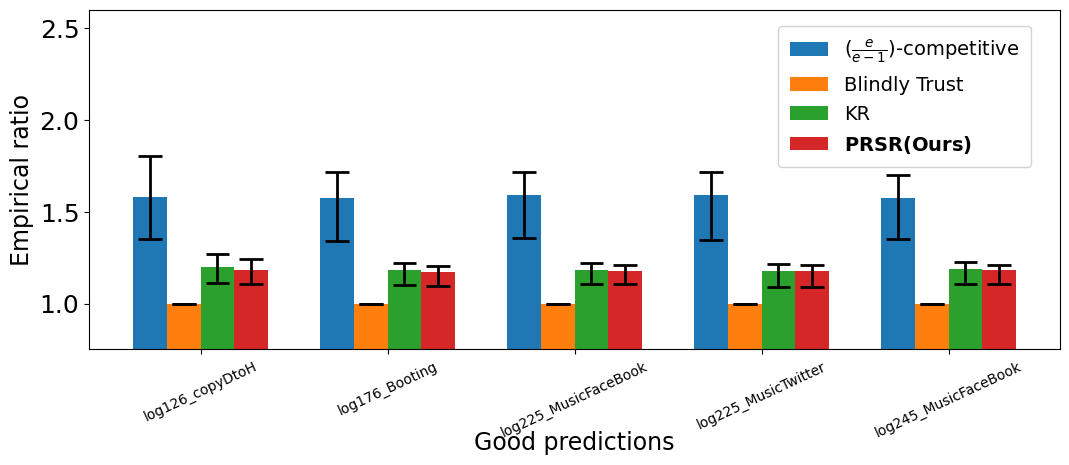

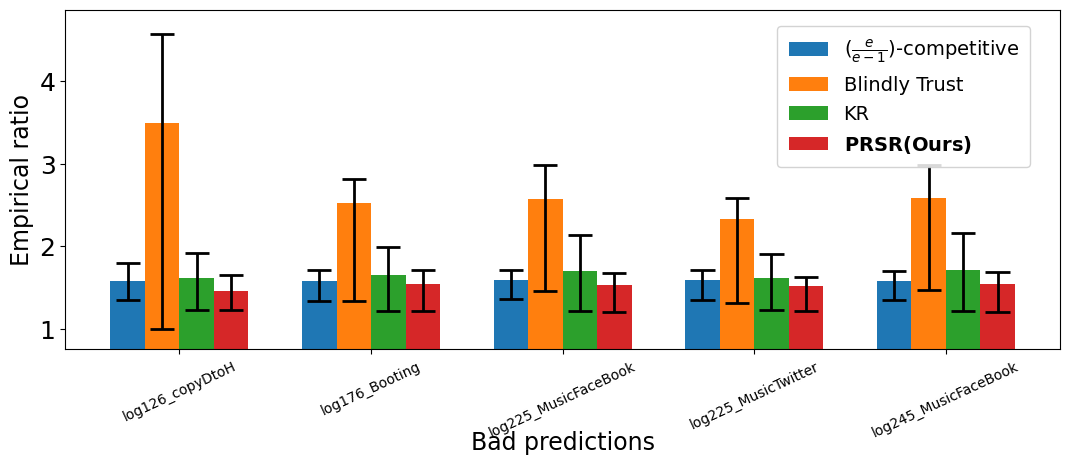

In [80]:
import matplotlib.pyplot as plt
import numpy as np
import os

# =========================
# Helpers
# =========================
def get_mean_iqr(df, group, method):
    base = f"{group} / {method}"
    return (
        df[(base, "mean")].to_numpy(dtype=float),
        df[(base, "q25")].to_numpy(dtype=float),
        df[(base, "q75")].to_numpy(dtype=float),
    )

def draw_mean_with_iqr(ax, x, mean, q25, q75, width, color, label=None):
    ax.bar(
        x, mean,
        width=width,
        color=color,
        label=label,
        zorder=2
    )

    ax.vlines(
        x, q25, q75,
        color="black",
        linewidth=2.0,
        zorder=3
    )

    cap = width * 0.35
    ax.hlines(q25, x - cap, x + cap, color="black", linewidth=2.0, zorder=3)
    ax.hlines(q75, x - cap, x + cap, color="black", linewidth=2.0, zorder=3)

def plot_one_group(df, group, out_name, ylim=None):
    labels = df[("", "File")].tolist()

    methods = ["Competitive", "FTP", "Kumar", "PRSR"]
    display_names = {
        "Competitive": r"$(\frac{e}{e-1})$-competitive",
        "FTP": "Blindly Trust",
        "Kumar": "KR",
        "PRSR": r"$\mathbf{PRSR(Ours)}$"
    }
    colors = {
        "Competitive": "#1f77b4",
        "FTP": "#ff7f0e",
        "Kumar": "#2ca02c",
        "PRSR": "#d62728"
    }

    bar_width = 0.18
    x = np.arange(len(labels))

    fig, ax = plt.subplots(figsize=(10.8, 4.6))

    for i, method in enumerate(methods):
        offset = (i - 1.5) * bar_width
        mean, q25, q75 = get_mean_iqr(df, group, method)

        draw_mean_with_iqr(
            ax,
            x + offset,
            mean, q25, q75,
            bar_width,
            colors[method],
            label=display_names[method]
        )

    ax.set_ylabel("Empirical ratio", fontsize=17)
    plt.tick_params(axis='y', labelsize=18)

    if ylim is not None:
        ax.set_ylim(*ylim)
    else:
        ax.set_ylim(0.75, None)

    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=25, ha="center", fontsize=10)

    # ===== Group label：往下挪一点点 =====
    ymin, ymax = ax.get_ylim()
    ax.text(
        (x[0] + x[-1]) / 2,
        ymin - 0.24 * (ymax - ymin),   # ← 比之前更低
        group,
        ha="center",
        va="top",
        fontsize=17
    )

    # ===== Legend：图内右上角 =====
    ax.legend(
        loc="upper right",
        bbox_to_anchor=(0.98, 0.98),  # 右上角内缩
        fontsize=14,
        frameon=True,
        fancybox=True,
        framealpha=0.85,
        borderpad=0.6
    )

    plt.subplots_adjust(bottom=0.36, left=0.08, right=0.98, top=0.96)
    plt.tight_layout()

    desktop = os.path.join(os.path.expanduser("~"), "Desktop")
    plt.savefig(os.path.join(desktop, out_name), bbox_inches="tight")
    plt.show()

# =========================
# Make two separate figures
# =========================
plot_one_group(df, "Good predictions", "DMP_good_mean_IQR.pdf", ylim=(0.75, 2.6))
plot_one_group(df, "Bad predictions",  "DMP_bad_mean_IQR.pdf",  ylim=(0.75, 4.87))

# Moderate Prediction

In [81]:
def moderate_pred(requests, std=5):
    noise = np.random.normal(0, std, size=len(requests))
    preds = np.maximum(requests + noise, 0)
    return preds

def run_moderate(file, lambd, gamma):
    requests = file
    moderate_predictions = moderate_pred(requests)

    # OPT per t
    opt_history = OPT_multiple(requests)
    opt_cost = np.asarray(Cost_from_history(requests, opt_history), dtype=float)

    eps = 1e-12
    denom = np.maximum(opt_cost, eps)

    # Competitive (prediction-free)
    comp_cost = np.asarray(
        Cost_from_history(requests, RandomOnline_multiple(requests)),
        dtype=float
    )
    comp_ratio = comp_cost / denom

    # Moderate prediction histories
    FTP_cost = np.asarray(
        Cost_from_history(requests, FTP_multiple(requests, moderate_predictions)),
        dtype=float
    )
    Kumar_cost = np.asarray(
        Cost_from_history(requests, Kumar_multiple(requests, moderate_predictions, lambd)),
        dtype=float
    )
    PRSR_cost = np.asarray(
        Cost_from_history(requests, PRSR_multiple(requests, moderate_predictions, gamma)),
        dtype=float
    )

    ratios = {
        "Competitive": comp_ratio,
        "FTP":         FTP_cost / denom,
        "Kumar":       Kumar_cost / denom,
        "PRSR":        PRSR_cost / denom,
    }

    return ratios

stats_order = ["min", "q25", "median", "mean", "q75", "max"]

records = []
for name, data in file_names.items():
    ratios = run_moderate(data, lambd=np.log(3/2), gamma=3)  

    row = {("", "File"): name}

    for method in ["Competitive", "FTP", "Kumar", "PRSR"]:
        stat = summarize_ratios(ratios[method])
        for s in stats_order:
            row[(f"Moderate predictions / {method}", s)] = stat[s]

    records.append(row)

df = pd.DataFrame(records)

cols = [("", "File")]
for method in ["Competitive", "FTP", "Kumar", "PRSR"]:
    for s in stats_order:
        cols.append((f"Moderate predictions / {method}", s))

df = df.reindex(columns=pd.MultiIndex.from_tuples(cols))

print(df.to_string(index=False, float_format=lambda x: f"{x:.3f}"))


                     Moderate predictions / Competitive                                Moderate predictions / FTP                                 Moderate predictions / Kumar                                Moderate predictions / PRSR                               
                File                                min   q25 median  mean   q75   max                        min   q25 median  mean   q75    max                          min   q25 median  mean   q75   max                         min   q25 median  mean   q75   max
     log126_copyDtoH                              1.000 1.359  1.565 1.583 1.804 4.037                      1.000 1.000  1.000 1.518 1.246 11.823                        1.000 1.160  1.260 1.372 1.394 3.289                       1.000 1.162  1.272 1.367 1.492 3.254
      log176_Booting                              1.000 1.356  1.519 1.593 1.722 6.145                      1.000 1.000  1.266 1.754 2.164 11.336                        1.000 1.173  1.321 1.510 1.782 3.442

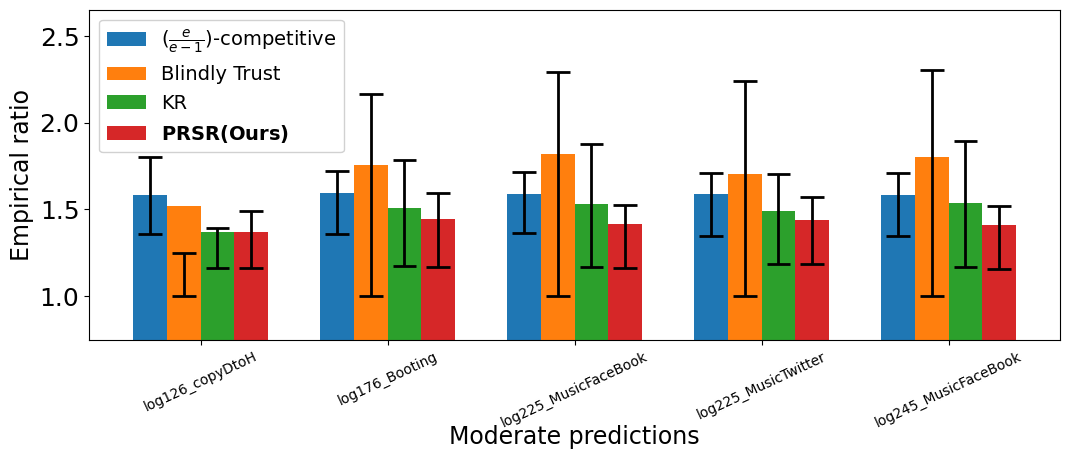

In [82]:
import matplotlib.pyplot as plt
import numpy as np
import os

# =========================
# Helpers
# =========================
def get_mean_iqr(df, group, method):
    base = f"{group} / {method}"
    return (
        df[(base, "mean")].to_numpy(dtype=float),
        df[(base, "q25")].to_numpy(dtype=float),
        df[(base, "q75")].to_numpy(dtype=float),
    )

def draw_mean_with_iqr(ax, x, mean, q25, q75, width, color, label=None):
    # mean bar
    ax.bar(
        x,
        mean,
        width=width,
        color=color,
        label=label,
        zorder=2
    )

    # IQR error bar
    ax.vlines(
        x,
        q25,
        q75,
        color="black",
        linewidth=2.0,
        zorder=3
    )

    # caps
    cap = width * 0.35
    ax.hlines(q25, x - cap, x + cap, color="black", linewidth=2.0, zorder=3)
    ax.hlines(q75, x - cap, x + cap, color="black", linewidth=2.0, zorder=3)

# =========================
# Plot
# =========================
labels = df[("", "File")].tolist()

methods = ["Competitive", "FTP", "Kumar", "PRSR"]
display_names = {
    "Competitive": r"$(\frac{e}{e-1})$-competitive",
    "FTP": "Blindly Trust",
    "Kumar": "KR",
    "PRSR": r"$\mathbf{PRSR(Ours)}$"
}

colors = {
    "Competitive": "#1f77b4",
    "FTP": "#ff7f0e",
    "Kumar": "#2ca02c",
    "PRSR": "#d62728"
}

bar_width = 0.18
x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(10.8, 4.6))

group = "Moderate predictions"

# Draw bars
for i, method in enumerate(methods):
    offset = (i - 1.5) * bar_width
    mean_m, q25_m, q75_m = get_mean_iqr(df, group, method)

    draw_mean_with_iqr(
        ax,
        x + offset,
        mean_m, q25_m, q75_m,
        bar_width,
        colors[method],
        label=display_names[method]
    )

# =========================
# Axes & labels
# =========================
ax.set_ylabel("Empirical ratio", fontsize=17)
ax.set_ylim(0.75, 2.65)
plt.tick_params(axis='y', labelsize=18)

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=25, ha="center", fontsize=10)

# single group label (optional but nice)
ymin, ymax = ax.get_ylim()
ax.text((x[0] + x[-1]) / 2, ymin - 0.18 * (ymax - ymin) - 0.15,
        group, ha="center", va="top", fontsize=17)

# Legend
ax.legend(
    loc="upper left",
    fontsize=14,
    frameon=True,
    fancybox=True,
    framealpha=0.9
)

plt.subplots_adjust(bottom=0.32, left=0.08, right=0.98, top=0.96)
plt.tight_layout()

desktop = os.path.join(os.path.expanduser("~"), "Desktop")
plt.savefig(os.path.join(desktop, "DMP_moderate_mean_IQR.pdf"), bbox_inches="tight")
plt.show()